In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import GaussianMixture
import numpy as np


In [20]:
import os
print(os.getcwd())


C:\Users\st114\OneDrive\Documents\Fall BU 2025\CS 777 Big Data Analytics\Term Project\wedding-song-recommendations\modeling


In [21]:
# creating spark app
spark = SparkSession.builder.appName("Creating_Clustering_Model").getOrCreate()

#reading in the CSV file 
df = spark.read.csv('numpy_array_for_modeling.csv', header=True, inferSchema=True)

df.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)



In [22]:
input_columns =  ["rank","trend","streams","popularity","duration_ms","af_danceability","af_energy","af_key","af_loudness","af_mode","af_speechiness","af_acousticness","af_instrumentalness","af_liveness","af_valence","af_tempo","af_time_signature","language_id","date"]
vector_assembler = VectorAssembler(inputCols = input_columns, 
                            outputCol = 'vectorized_features')

vector_dataframe = vector_assembler.transform(df) # df is our data without being vectorized
transformed_vectors = vector_dataframe.select('vectorized_features') # selecting the vectorized features so we can use them in a model
transformed_vectors.show(5)

+--------------------+
| vectorized_features|
+--------------------+
|[1.0,1.0,253019.0...|
|[2.0,2.0,223988.0...|
|[3.0,0.0,210943.0...|
|[4.0,1.0,173865.0...|
|[5.0,2.0,153956.0...|
+--------------------+
only showing top 5 rows



In [23]:
vector_dataframe.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)
 |-- vectorized_features: vector (nullable = true)



In [24]:
transformed_vectors.printSchema()

root
 |-- vectorized_features: vector (nullable = true)



In [25]:
#scaling the data for k-means since it's a distance based algorithm 
scaler = StandardScaler(inputCol = 'vectorized_features',
                       outputCol = 'scaled_vectorized_features',
                       withStd = True,
                       withMean = False)
#check the summary statistics of our resutls by fitting the standard scaler
scalerModel = scaler.fit(vector_dataframe)

#normalizing each feature to have unit standard deviation
vector_dataframe_scaled = scalerModel.transform(vector_dataframe)

#showing the scaled features
vector_dataframe_scaled.select('scaled_vectorized_features').show(5)

+--------------------------+
|scaled_vectorized_features|
+--------------------------+
|      [0.01746800914601...|
|      [0.03493601829202...|
|      [0.05240402743804...|
|      [0.06987203658405...|
|      [0.08734004573006...|
+--------------------------+
only showing top 5 rows



In [26]:
vector_dataframe_scaled.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- scaled_vectorized_features: vector (nullable = true)



In [27]:
# #let's evaluate the clusting by computing within the Set sum of squared errors
# wsse = model.summary.trainingCost
# print(f"Within Set Sum of Squared Errors = {wsse}")

# # show cluster centers
# centers= model.clusterCenters()
# print('Cluster Centers')
# for center in centers:
#     print(center)


In [28]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

sil_score = []
evaluator = ClusteringEvaluator(predictionCol = 'prediction',
                               featuresCol = 'scaled_vectorized_features',
                               metricName = 'silhouette',
                               #distanceMeasure = 'squaredEuclidean' 
                               distanceMeasure = 'cosine') #cosine gives us better results
for i in range(2,15):
    kmeans = KMeans(featuresCol = 'scaled_vectorized_features', k = i)
    model = kmeans.fit(vector_dataframe_scaled)
    predictions = model.transform(vector_dataframe_scaled)
    score = evaluator.evaluate(predictions)
    sil_score.append(score)
    print("Silhouette Score for K = ", i , 'is', score)


Silhouette Score for K =  2 is 0.17303386031003062
Silhouette Score for K =  3 is 0.1717752612647778
Silhouette Score for K =  4 is 0.16278110672127039
Silhouette Score for K =  5 is 0.04175601950134186
Silhouette Score for K =  6 is 0.18201786315220464
Silhouette Score for K =  7 is 0.08352147930716775
Silhouette Score for K =  8 is 0.1442712565443439
Silhouette Score for K =  9 is 0.06304901479439572
Silhouette Score for K =  10 is 0.1181357374567641
Silhouette Score for K =  11 is 0.12191968542807764
Silhouette Score for K =  12 is 0.05151725104047755
Silhouette Score for K =  13 is 0.11815175126221357
Silhouette Score for K =  14 is 0.09188814292746887


Scores without scaling:


Silhouette Score for K =  2 is 0.8385888534419206

Silhouette Score for K =  3 is 0.8385888534419206

Silhouette Score for K =  4 is 0.8385888534419206

Silhouette Score for K =  5 is 0.8385888534419206

Silhouette Score for K =  6 is 0.8385888534419206

Silhouette Score for K =  7 is 0.8385888534419206

Silhouette Score for K =  8 is 0.8385888534419206

Silhouette Score for K =  9 is 0.8385888534419206


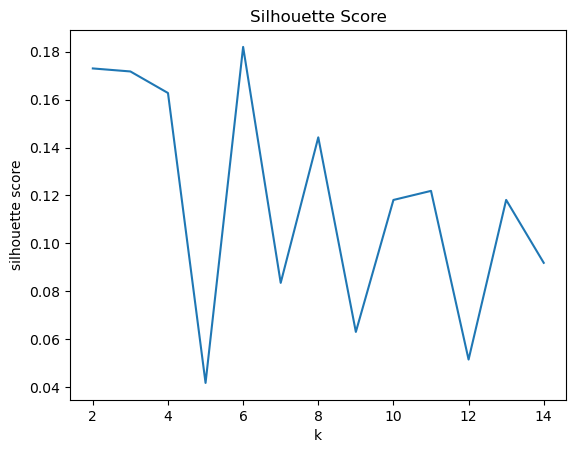

In [29]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,15),sil_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [30]:
#it seems that the best results happen when k is 5
#let's train the model 
kmeans = KMeans(featuresCol = 'scaled_vectorized_features', k =5)
model = kmeans.fit(vector_dataframe_scaled)
predictions = model.transform(vector_dataframe_scaled)

In [31]:
# printing the cluster centers 
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 1.82540696e+00  1.86384325e+00  7.24792195e-01  1.36140316e+00
  4.78794240e+00  8.05679485e+00  6.56489679e+00  1.38753945e+00
 -3.18942939e+00  1.24418450e+00  9.90667069e-01  1.04667348e+00
  2.02640191e-02  1.06592228e+00  4.94085408e+00  3.32755979e+00
  1.37477533e+01  2.06790009e+00  2.59493171e+02]
[ 1.65696544e+00  1.06819503e-01  9.06617224e-01  1.20504599e+00
  5.92540865e+00  7.85050851e+00  4.98397406e+00  1.49766163e+00
 -4.07601206e+00  1.15108226e+00  1.44389495e+00  1.86755001e+00
  3.18480386e-02  1.10299951e+00  3.06292828e+00  3.41970927e+00
  1.44468753e+01  7.32381282e-01  2.59602108e+02]
[ 2.65254954e-01  1.24622754e+00  2.96133941e+00  1.26754173e+00
  5.85827293e+00  7.84836717e+00  7.05702343e+00  1.52828049e+00
 -2.30487961e+00  8.20679020e-01  1.87223642e+00  1.06020633e+00
  2.63493091e-03  1.37065852e+00  4.32091181e+00  3.73818283e+00
  1.41109015e+01  1.79026536e+00  2.59619142e+02]
[ 2.21013270e+00  2.57417492e-01  6.35082074e-01  1.

In [32]:
predictions.select('prediction').show(20)

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         1|
|         2|
|         2|
+----------+
only showing top 20 rows



In [37]:


results = [] 
for i in range(2,11): 
    gmm_model = GaussianMixture(k = i,
                                featuresCol = 'scaled_vectorized_features', 
                                predictionCol = 'gmm_predictions') 
    model = gmm_model.fit(vector_dataframe_scaled) 
    lllh = model.summary.logLikelihood 
    results.append((i,lllh)) 

print(results)

[(2, -3941.917860621552), (3, -3676.0928437452776), (4, -3641.0906274677964), (5, 997.44958526081), (6, 1892.1553109588094), (7, -314.62299976325886), (8, 3040.5829799958483), (9, 4105.538177715193), (10, 3033.7688779302352)]


In [34]:
#implementation of GMM 
# choosing the number of components that would perform better
# in the previous section, we found that it was 5



n_components = 6

gmm = GaussianMixture(k = n_components, 
                      featuresCol = 'scaled_vectorized_features', 
                      predictionCol = 'gmm_predictions')
model = gmm.fit(vector_dataframe_scaled)
# predict where each song lies 
df_with_gmm_predictions = model.transform(vector_dataframe_scaled)

In [35]:
df_with_gmm_predictions.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- scaled_vectorized_features: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- gmm_predictions: integer (nullable =

In [36]:
df_with_gmm_predictions.select('gmm_predictions').show(10)

+---------------+
|gmm_predictions|
+---------------+
|              0|
|              0|
|              0|
|              0|
|              0|
|              3|
|              1|
|              5|
|              1|
|              1|
+---------------+
only showing top 10 rows

